In [1]:
import os
import mne
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam, RMSprop

In [2]:
data_dir = 'Preprocessed Data MI'
epoch_data_path = os.path.join(os.getcwd(), data_dir + '\Epoch')
dirs = os.listdir(os.path.join(os.getcwd(), 'Dataset Motor Imagery'))
eeg_data = [mne.read_epochs(os.path.join(epoch_data_path, epoch_file)) for epoch_file in os.listdir(epoch_data_path)]

Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160405-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
959 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectA-160408-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     845.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
867 matching events found
No baseline correction applied
0 projection items activated
Reading C:\Users\hanin\Documents\Kuliah\Semester 7\Tugas Akhir\Preprocessed Data MI\Epoch\SubjectB-151110-epo.fif ...
    Found the data of interest:
        t =       0.00 ...     850.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting 

In [3]:
epoch_data = []
epoch_label = []
subject_last_index = []
# scaler = StandardScaler()
for i in range(len(eeg_data)):
    eeg_data[i] = eeg_data[i].crop(tmin = 0, tmax = 0.845, include_tmax = True)
    for epoch in eeg_data[i].get_data():
#         epoch = scaler.fit_transform(epoch)
        epoch_data.append(np.reshape(epoch, newshape = (epoch.shape[0], epoch.shape[1], 1)))
    for event in eeg_data[i].events:
        epoch_label.append(event[2] - 1)
    subject_last_index.append((dirs[i].split('-')[1], len(epoch_data) - 1))
epoch_data = np.asarray(epoch_data, dtype = np.float32)
epoch_label = np.asarray(epoch_label, dtype = np.int32)

In [4]:
subject_index = {}
for subject, last_index in subject_last_index:
    if subject not in subject_index:
        subject_index[subject] = last_index
    if last_index > subject_index[subject]:
        subject_index[subject] = last_index
subject_index

{'SubjectA': 1825,
 'SubjectB': 5636,
 'SubjectC': 7535,
 'SubjectE': 10383,
 'SubjectF': 13257,
 'SubjectG': 15158,
 'SubjectH': 16080,
 'SubjectI': 17997}

In [5]:
def retrieve_data(subject_name):
    index_list = list(subject_index.values())
    subj_idx = list(subject_index.keys()).index(subject_name)
    if subj_idx - 1 < 0:
        data_index = list(range(index_list[subj_idx]))
    else:
        data_index = list(range(index_list[subj_idx - 1], index_list[subj_idx]))
    return epoch_data[data_index], epoch_label[data_index]

def sliding_window(data, new_data_len, data_gap):
    new_data_indices = []
    data_len = len(data)
    data_start_index, data_end_index = 0, new_data_len
    while data_end_index <= data_len:
        new_data_indices.append(list(range(data_start_index, data_end_index)))
        data_start_index += data_gap
        data_end_index += data_gap
    new_data = [data[data_indices] for data_indices in new_data_indices]
    return new_data

def add_noise(data, std_dev, mean = 0):
    noise = np.random.normal(mean, std_dev, size = data.shape)
    new_data = data + noise
    return new_data

def create_cnn(input_shape, optimizer = None):
    conv1_init = tf.keras.initializers.GlorotUniform(42)
    conv2_init = tf.keras.initializers.GlorotUniform(42)
    dense1_init = tf.keras.initializers.GlorotUniform(24)
    dense2_init = tf.keras.initializers.GlorotUniform(24)
    model = Sequential([
        Conv2D(filters = 64, kernel_size = (1, 5), padding = 'same', input_shape = input_shape,
               activation = 'relu', kernel_initializer = conv1_init),
        Conv2D(filters = 64, kernel_size = (input_shape[0], 1), activation = 'relu',
               kernel_initializer = conv2_init),
        AveragePooling2D(pool_size = (1, 2)),
        Flatten(),
        Dense(units = 32, activation = 'elu', kernel_initializer = dense1_init),
        Dense(units = 5, activation = 'softmax', kernel_initializer = dense2_init)
    ])
    if optimizer is None:
        model.compile(loss = 'categorical_crossentropy', optimizer = Adam(5 * 1e-5),
                      metrics = ['accuracy'])
    else:
        model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

In [6]:
subject_name = 'SubjectG'
data, labels = retrieve_data(subject_name)

In [7]:
data_length, data_gap = 150, 10
copy_data = data.copy()
epoch_data, epoch_label = [], []
for index, data in enumerate(copy_data):
    augmented_data = []
    for channel_index in range(data.shape[0]):
        augmented_data.append(sliding_window(data[channel_index, :, 0], data_length, data_gap))
    augmented_data = np.array(augmented_data)
    for data_index in range(augmented_data.shape[1]):
        new_data = augmented_data[:, data_index]
        new_label = labels[index]
        epoch_data.append(new_data)
        epoch_label.append(new_label)
epoch_data = np.array(epoch_data)
epoch_label = np.array(epoch_label)

In [8]:
print('Data shape: {}'.format(epoch_data.shape))

Data shape: (5703, 21, 150)


In [9]:
model = create_cnn(input_shape = (21, 150, 1))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 21, 150, 64)       384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 150, 64)        86080     
_________________________________________________________________
average_pooling2d (AveragePo (None, 1, 75, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 4800)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                153632    
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 165       
Total params: 240,261
Trainable params: 240,261
Non-trainable params: 0
__________________________________________________

In [10]:
shuffled_indices = np.arange(epoch_data.shape[0])
np.random.shuffle(shuffled_indices)

In [11]:
epoch_data = epoch_data[shuffled_indices]
epoch_label = epoch_label[shuffled_indices]

In [12]:
train_data, test_data, train_labels, test_labels = train_test_split(epoch_data, epoch_label, test_size = 0.1,
                                                                    stratify = epoch_label, random_state = 42)
# train_data = tf.expand_dims(train_data, axis = -1)
# test_data = tf.expand_dims(test_data, axis = -1)
# train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = len(np.unique(epoch_label)))
# test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = len(np.unique(epoch_label)))

In [43]:
std_devs = [0.5, 0.6]
copy_data = train_data.copy()
train_data, train_labels = list(train_data), list(train_labels)
for index, data in enumerate(copy_data):
    for dev in std_devs:
        train_data.append(add_noise(data, std_dev = dev))
        train_labels.append(train_labels[index])
train_data, train_labels = np.array(train_data), np.array(train_labels)

In [13]:
train_data = tf.expand_dims(train_data, axis = -1)
test_data = tf.expand_dims(test_data, axis = -1)
train_labels = tf.keras.utils.to_categorical(train_labels, num_classes = len(np.unique(epoch_label)))
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes = len(np.unique(epoch_label)))

In [14]:
train_data.shape

TensorShape([5132, 21, 150, 1])

In [56]:
history = model.fit(train_data, train_labels, batch_size = 16, validation_data = (test_data, test_labels),
                    epochs = 30)

Epoch 1/30
321/321 [==============================] - 13s 41ms/step - loss: 1.5168 - accuracy: 0.3324 - val_loss: 1.3262 - val_accuracy: 0.3835
Epoch 2/30
321/321 [==============================] - 12s 39ms/step - loss: 1.2465 - accuracy: 0.4538 - val_loss: 1.2224 - val_accuracy: 0.4694
Epoch 3/30
321/321 [==============================] - 13s 40ms/step - loss: 1.1268 - accuracy: 0.5187 - val_loss: 1.1604 - val_accuracy: 0.5114
Epoch 4/30
321/321 [==============================] - 14s 44ms/step - loss: 1.0389 - accuracy: 0.5587 - val_loss: 1.1187 - val_accuracy: 0.5201
Epoch 5/30
321/321 [==============================] - 14s 44ms/step - loss: 0.9681 - accuracy: 0.5904 - val_loss: 1.1016 - val_accuracy: 0.5009
Epoch 6/30
321/321 [==============================] - 14s 45ms/step - loss: 0.9032 - accuracy: 0.6282 - val_loss: 1.1002 - val_accuracy: 0.5201
Epoch 7/30
321/321 [==============================] - 15s 46ms/step - loss: 0.8427 - accuracy: 0.6639 - val_loss: 1.0745 - val_accuracy:

In [20]:
predictions = model.predict(test_data)
epoch_label_pred = np.array([np.argmax(prediction) for prediction in predictions])
epoch_label_real = np.array([np.argmax(label) for label in test_labels])
print('Accuracy: {}'.format(accuracy_score(epoch_label_pred, epoch_label_real)))

Accuracy: 0.542907180385289


In [33]:
predictions = model.predict(test_data)
epoch_label_pred = np.array([np.argmax(prediction) for prediction in predictions])
epoch_label_real = np.array([np.argmax(label) for label in test_labels])
print('Accuracy: {}'.format(accuracy_score(epoch_label_pred, epoch_label_real)))

Accuracy: 0.5183887915936952


In [57]:
predictions = model.predict(test_data)
epoch_label_pred = np.array([np.argmax(prediction) for prediction in predictions])
epoch_label_real = np.array([np.argmax(label) for label in test_labels])
print('Accuracy: {}'.format(accuracy_score(epoch_label_pred, epoch_label_real)))

Accuracy: 0.5849387040280211


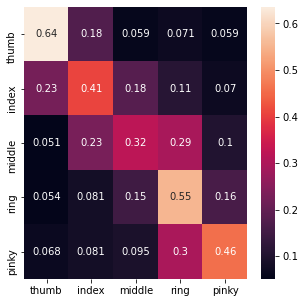

In [24]:
import seaborn as sn

label = ['thumb', 'index', 'middle', 'ring', 'pinky']
cm = confusion_matrix(epoch_label_real, epoch_label_pred, normalize = 'true')
df_cm = pd.DataFrame(cm, index = label, columns = label)
plt.figure(figsize = (5, 5))
sn.heatmap(df_cm, annot = True)
plt.savefig('Hasil/CM_{}_no_augment.png'.format(subject_name), facecolor = 'w', edgecolor = 'w')
plt.show()

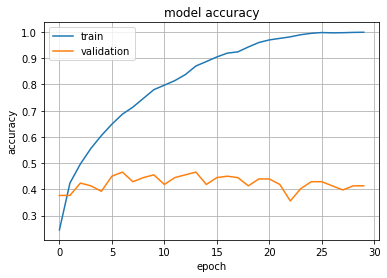

In [93]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.grid(True)
plt.savefig('Hasil/No Augment.png')
plt.show()

In [56]:
import random
data = random.choice(np.array(test_data))

In [57]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

successive_outputs = [layer.output for layer in model.layers[0:]]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# x = img_to_array(data)
x = data.reshape((1,) + data.shape)

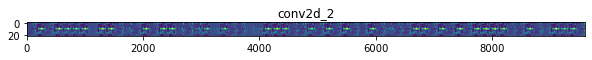

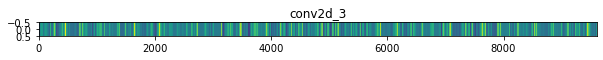

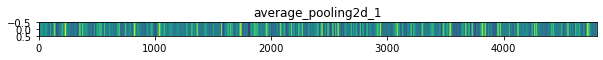

In [58]:
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
    if len(feature_map.shape) == 4:
        n_features = feature_map.shape[-1]  # number of features in the feature map
        height = feature_map.shape[1]  # feature map shape (1, size, size, n_features)
        width = feature_map.shape[2]
        display_grid = np.zeros((height, width * n_features))
    
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * width : (i + 1) * width] = x # Tile each filter into a horizontal grid

        scale = 20. / n_features
        if layer_name == 'conv2d':
            plt.figure(figsize = (12, 0.4))
        else:
            plt.figure(figsize = (10, 0.25))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect = 'auto', cmap = 'viridis') 

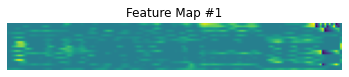

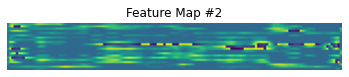

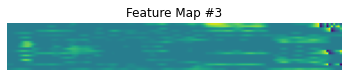

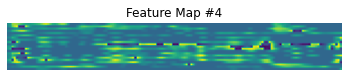

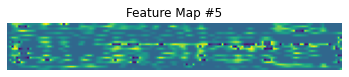

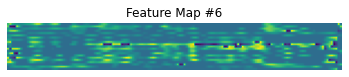

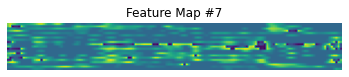

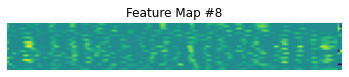

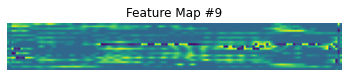

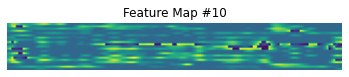

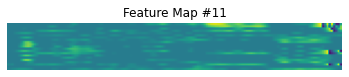

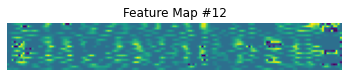

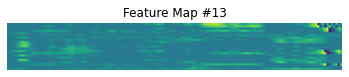

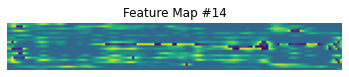

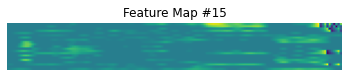

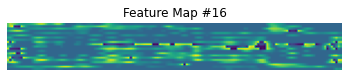

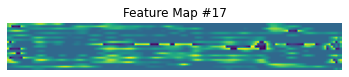

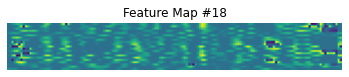

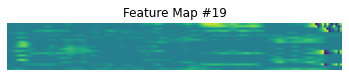

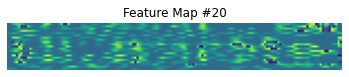

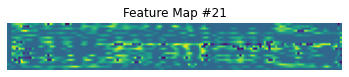

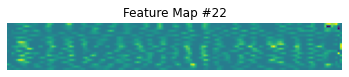

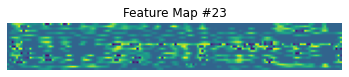

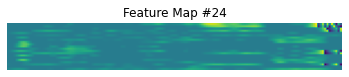

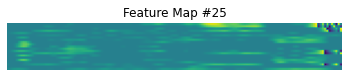

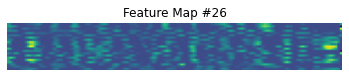

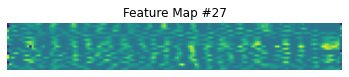

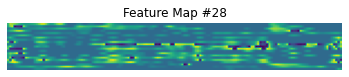

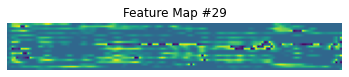

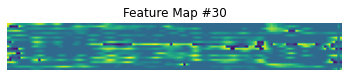

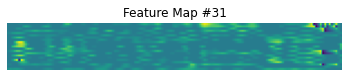

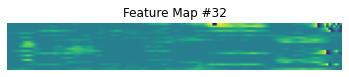

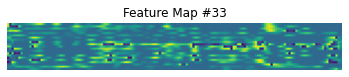

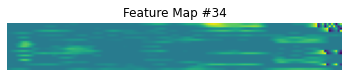

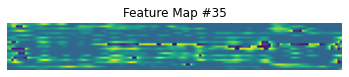

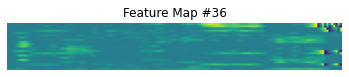

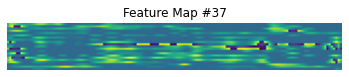

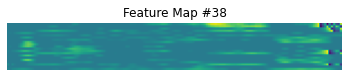

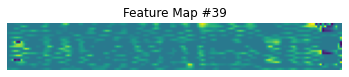

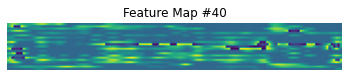

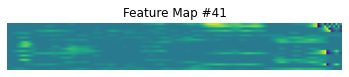

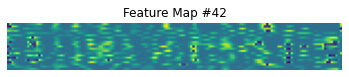

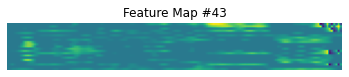

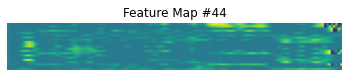

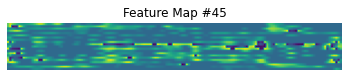

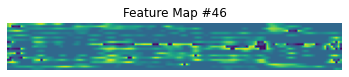

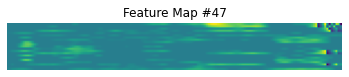

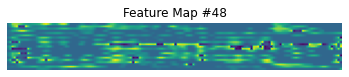

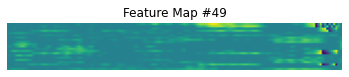

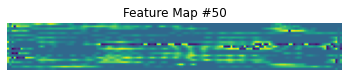

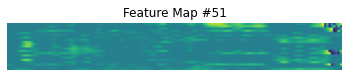

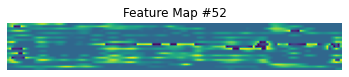

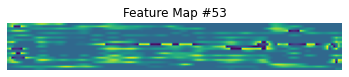

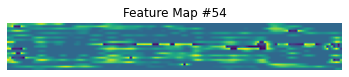

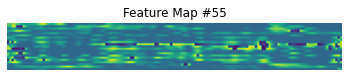

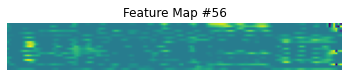

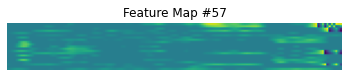

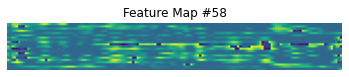

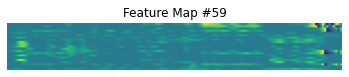

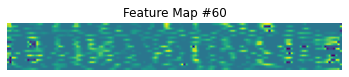

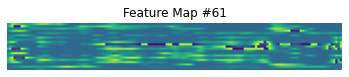

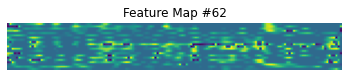

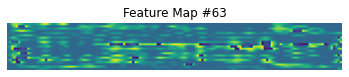

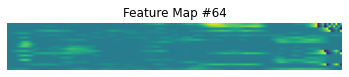

In [59]:
from PIL import Image
for index in range(successive_feature_maps[0].shape[3]):
    img = Image.fromarray(np.uint8(successive_feature_maps[0][0, :, :, index]))
    plt.imshow(img)
    plt.axis(False)
    plt.title('Feature Map #{}'.format(index + 1))
    plt.show()

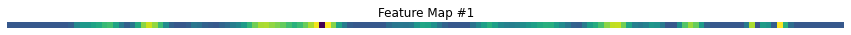

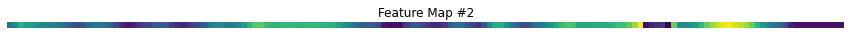

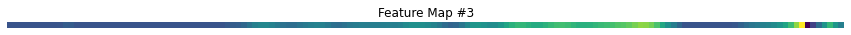

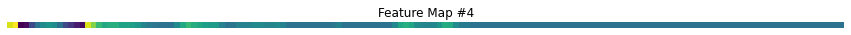

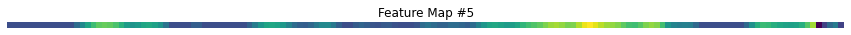

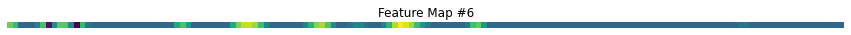

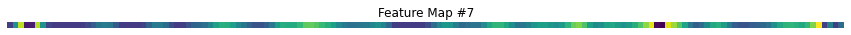

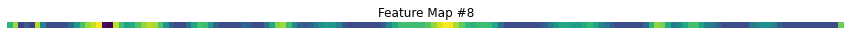

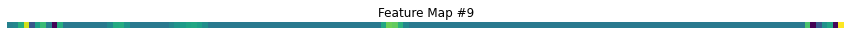

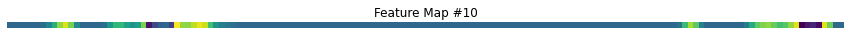

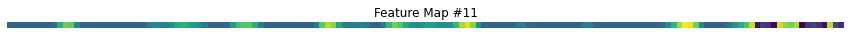

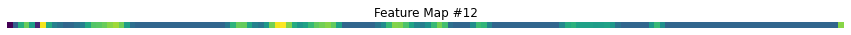

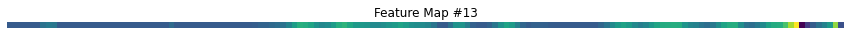

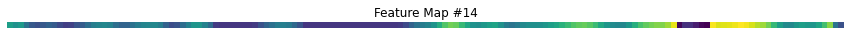

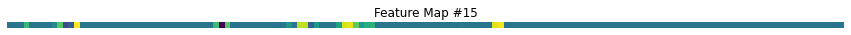

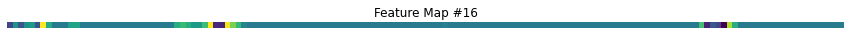

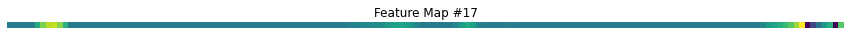

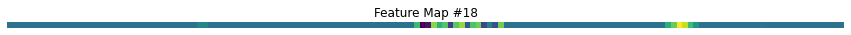

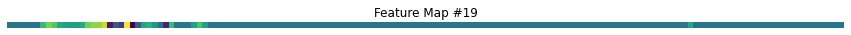

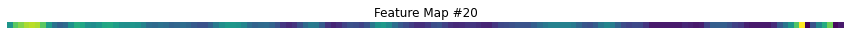

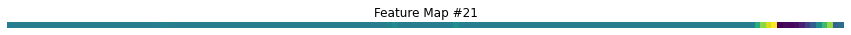

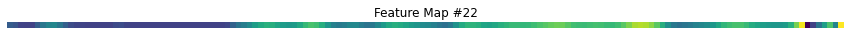

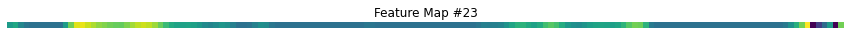

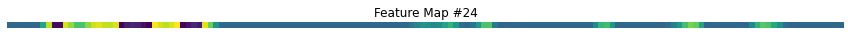

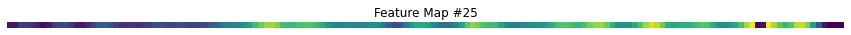

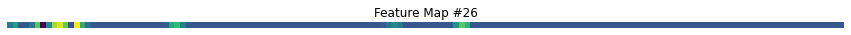

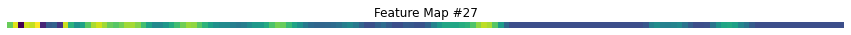

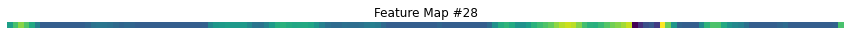

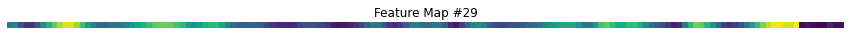

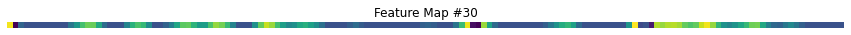

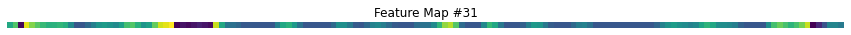

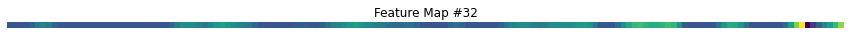

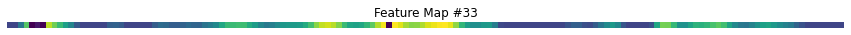

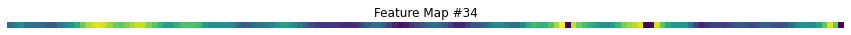

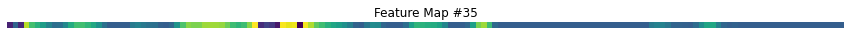

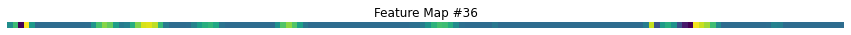

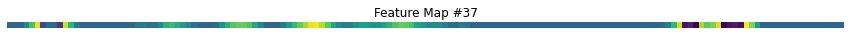

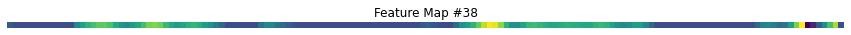

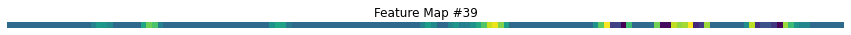

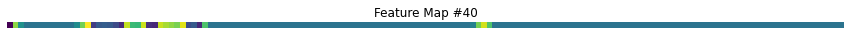

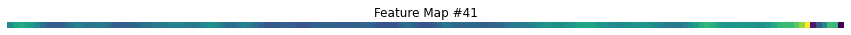

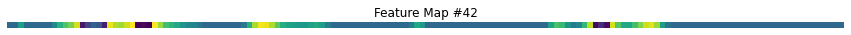

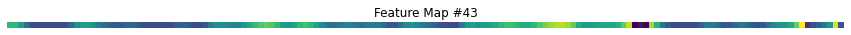

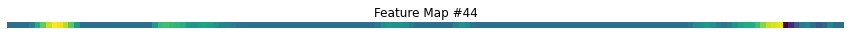

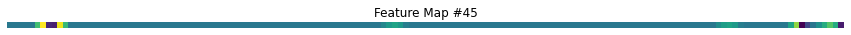

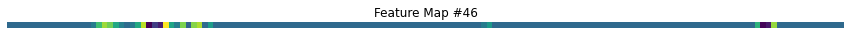

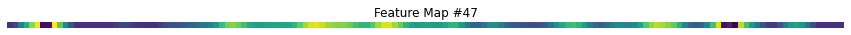

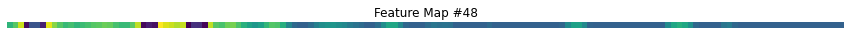

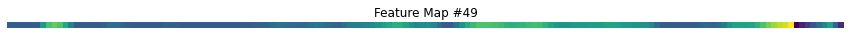

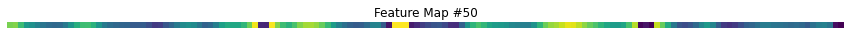

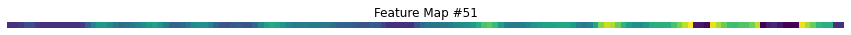

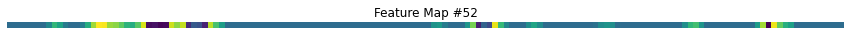

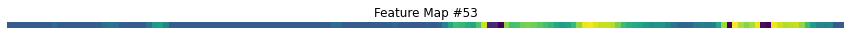

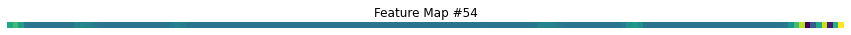

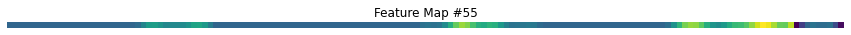

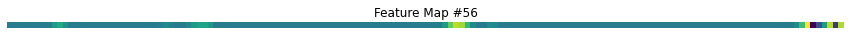

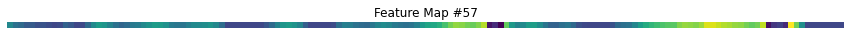

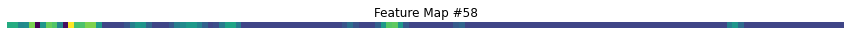

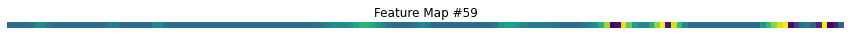

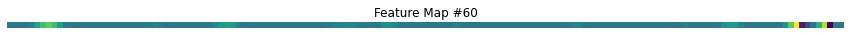

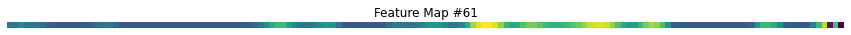

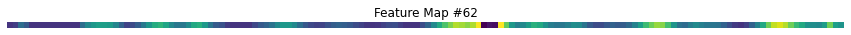

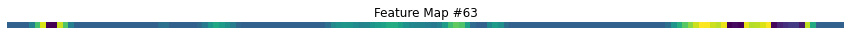

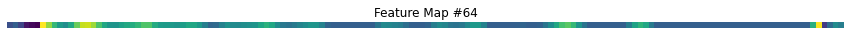

In [60]:
for index in range(successive_feature_maps[1].shape[3]):
    img = Image.fromarray(np.uint8(successive_feature_maps[1][0, :, :, index]))
    plt.figure(figsize = (15, 15))
    plt.imshow(img)
    plt.axis(False)
    plt.title('Feature Map #{}'.format(index + 1))
    plt.show()

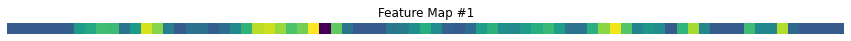

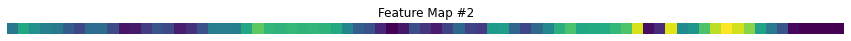

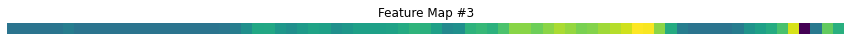

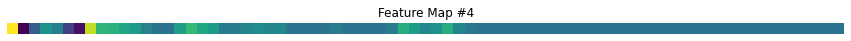

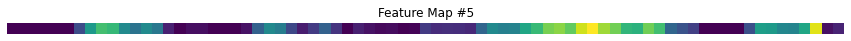

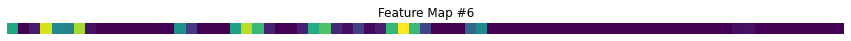

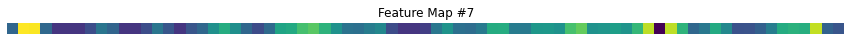

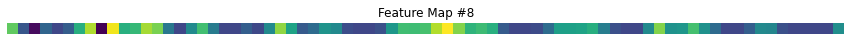

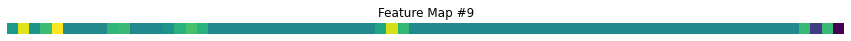

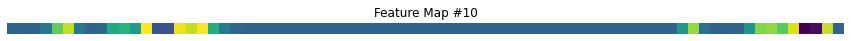

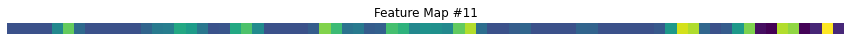

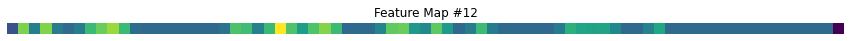

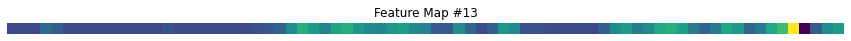

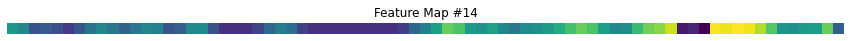

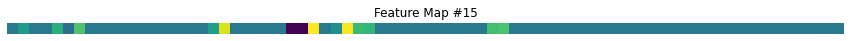

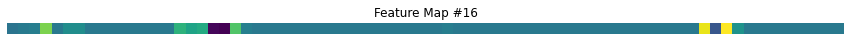

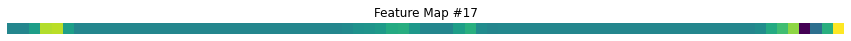

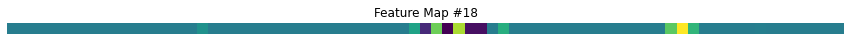

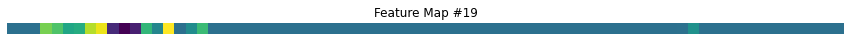

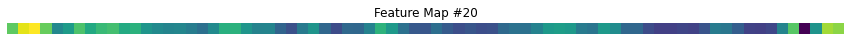

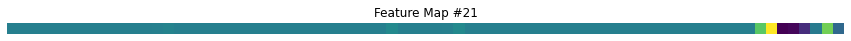

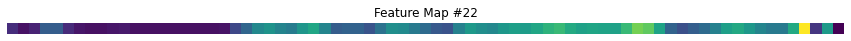

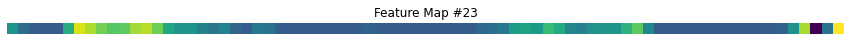

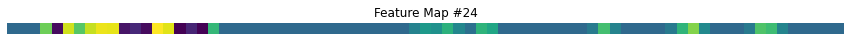

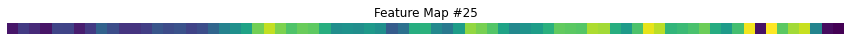

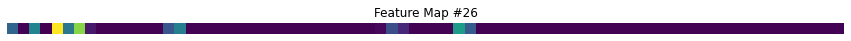

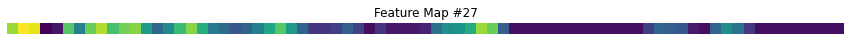

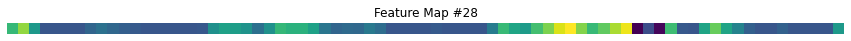

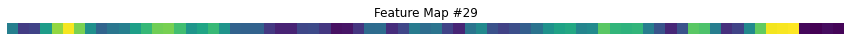

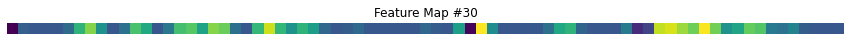

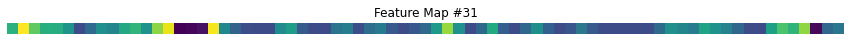

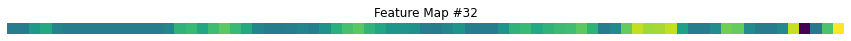

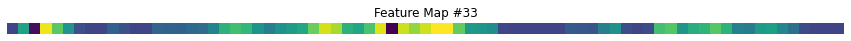

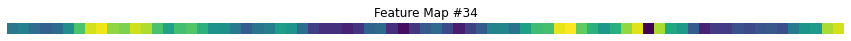

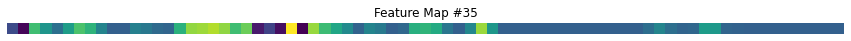

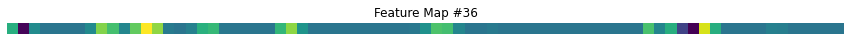

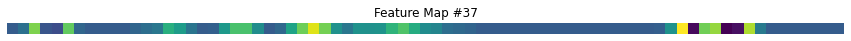

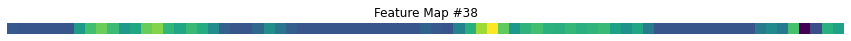

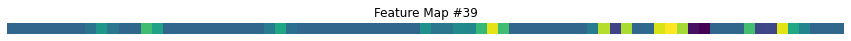

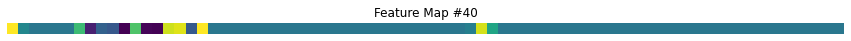

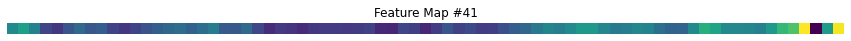

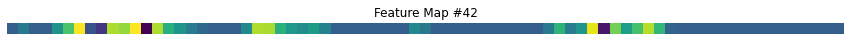

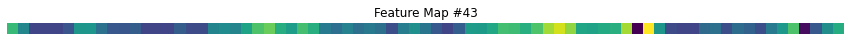

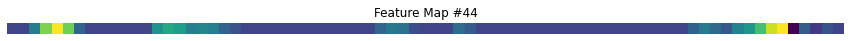

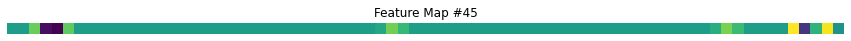

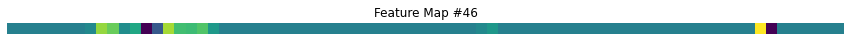

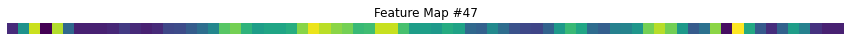

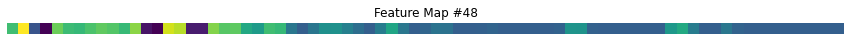

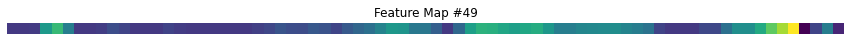

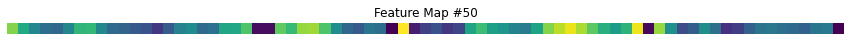

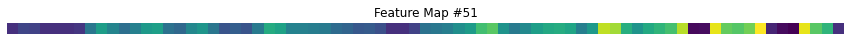

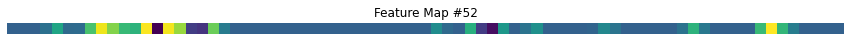

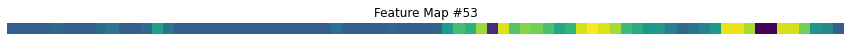

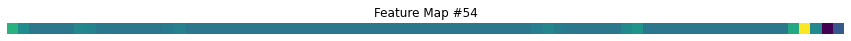

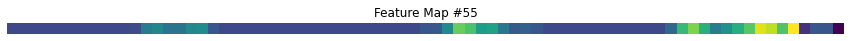

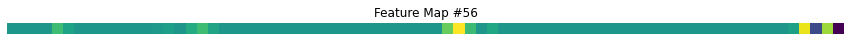

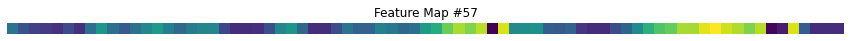

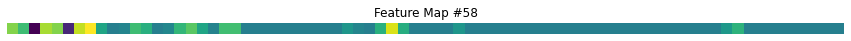

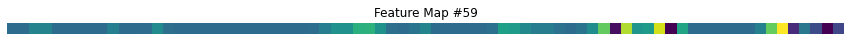

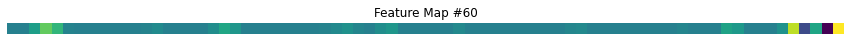

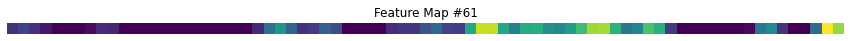

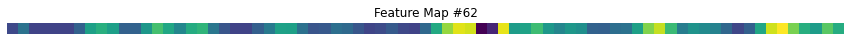

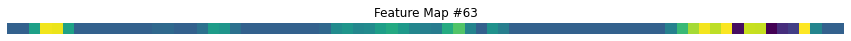

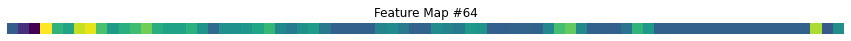

In [61]:
for index in range(successive_feature_maps[2].shape[3]):
    img = Image.fromarray(np.uint8(successive_feature_maps[2][0, :, :, index]))
    plt.figure(figsize = (15, 15))
    plt.imshow(img)
    plt.axis(False)
    plt.title('Feature Map #{}'.format(index + 1))
    plt.show()

In [62]:
indices = []
counter, max_count = 0, 50
for num_label in range(5):
    for index, label in enumerate(test_labels):
        if np.argmax(label) == num_label:
            indices.append(index)
            counter += 1
        if counter == max_count:
            counter = 0
            break

In [63]:
len(indices)

250

In [64]:
first_layer_result = []
for data in np.array(test_data)[indices]:
    data = data.reshape((1,) + data.shape)
    first_layer_result.append(visualization_model.predict(data)[-2][0])

In [65]:
pca = PCA(n_components = 2)
pca_result = pca.fit_transform(first_layer_result)
labels = np.array([np.argmax(label) for label in np.array(test_labels)[indices]]).reshape((len(pca_result),) + (1,))

In [66]:
df = pd.DataFrame(data = np.concatenate((pca_result, labels), axis = 1),
                  columns = ['PCA1', 'PCA2', 'Label'])

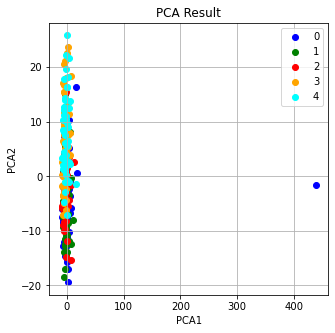

In [67]:
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_title('PCA Result')
targets = np.unique(labels)
colors = ['blue', 'green', 'red', 'orange', 'cyan']
for target, color in zip(targets, colors):
    keep_index = df['Label'] == target
    ax.scatter(df.loc[keep_index, 'PCA1'], df.loc[keep_index, 'PCA2'], c = color)
ax.legend(targets)
ax.grid(True)
plt.show()